## Scenario 1

Non-age structured model with b~=0

* training data: (samples of) WF model with $b\in[-0.001,0.0006]$
* observed data: samples (n=50,100,500,1000,2000) from WF model with specific $b_i$ values 
* outcome: 1-P(neutral)

We plot the $b_i$ values on the x-axis and the 1-P(neutral ) on the y-axis and compare this to the rejection probability obtained from the Ewens-Watterson test.

In [1]:
import os
import matplotlib.pyplot as plt
plt.style.use("science")

In [2]:
%run ../src/dataset.py
%run ../src/augmentation.py
%run ../src/simulation.py
%run ../src/utils.py

In [3]:
def load_data(fp, draws=1):
    data = {}
    for n in (100, 500, 1000, 2000):
        transform = Compose(Sampler(n=n, draws=draws), HillNumbers(q_step=0.25))
        data[n] = PresimulatedDataset.load(fp, transform=transform)
    return data

In [4]:
SCENARIO1_TRAINDATA = load_data("../data/scenario-1-trainset-new.npz")

In [105]:
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.inspection import permutation_importance

Estimator = RandomForestClassifier


with open("clf_params-rf.json") as f:
    PARAMS = json.load(f)

models = {}

for n in (100, 500, 1000, 2000):
    data = SCENARIO1_TRAINDATA[n]
    X, theta = data.dataset, data.theta
    X_train, X_dev, theta_train, theta_dev = train_test_split(
        X, theta, test_size=0.1, shuffle=True)

    y_train = (theta_train[:, 0].numpy() != 0).astype(int)
    y_dev = (theta_dev[:, 0].numpy() != 0).astype(int)
    
    clf = Estimator(n_jobs=4, **PARAMS[f"1-{n}"])
    clf.fit(X_train, y_train)

    probs = clf.predict_proba(X_dev)[:, 1]
    score = roc_auc_score(y_dev, probs)
    
    result = permutation_importance(
        clf, X_dev, y_dev, n_repeats=50, scoring="accuracy", n_jobs=4)
    
    models[n] = {
        "clf": clf,
        "dev score": score,
        "permutation importances": result.importances_mean,
        "impurity importances": clf.feature_importances_
    }

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.00875e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [41]:
evaluation_scores = []

features = [0, 4, 8, 12]

for i in features:
    for n in (100, 500, 1000, 2000):
        data = SCENARIO1_TRAINDATA[n]
        ff = [q for q in features if q != i]
        X, theta = data.dataset[:, ff], data.theta
        X_train, X_dev, theta_train, theta_dev = train_test_split(
            X, theta, test_size=0.1, shuffle=True, random_state=0)

        y_train = (theta_train[:, 0].numpy() != 0).astype(int)
        y_dev = (theta_dev[:, 0].numpy() != 0).astype(int)

        clf = Estimator(n_jobs=4, **PARAMS[f"1-{n}"])
        clf.fit(X_train, y_train)

        probs = clf.predict_proba(X_dev)[:, 1]
        score = roc_auc_score(y_dev, probs)

        evaluation_scores.append(
            {
                "n": n,
                "score": score,
                "eliminated": q_values[i],
            }
        )

In [ ]:
import pandas as pd

evaluation_scores = pd.DataFrame(evaluation_scores)
evaluation_scores = pd.pivot_table(evaluation_scores, values="score", index="eliminated", columns="n")

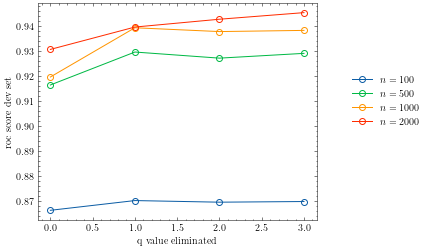

In [85]:
fig, ax = plt.subplots(figsize=(5, 4))

for n in (100, 500, 1000, 2000):
    ax.plot(evaluation_scores.index, evaluation_scores[n], '-o', fillstyle='none', label=f"$n = {n}$")
ax.set(xlabel="q value eliminated", ylabel="roc score dev set")
ax.legend(ncol=1, loc="center right", bbox_to_anchor=(1.4, 0.55))
plt.savefig("../plots/feature-elimination.png", dpi=300)

In [30]:
models

{100: {'clf': RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2',
                         min_samples_leaf=4, min_samples_split=12,
                         n_estimators=1100, n_jobs=10),
  'dev score': 0.8563148041474653,
  'permutation importances': array([ 0.00114,  0.00522,  0.00504,  0.00222,  0.0015 , -0.0019 ,
          0.00054, -0.00104,  0.00016,  0.00272,  0.0168 ,  0.03596,
          0.04816]),
  'impurity importances': array([0.01309438, 0.02457517, 0.02919765, 0.03399001, 0.0387815 ,
         0.05680008, 0.07438642, 0.08089132, 0.07774834, 0.11959205,
         0.13215841, 0.15358247, 0.16520219])},
 500: {'clf': RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=3,
                         min_samples_split=8, n_estimators=1500, n_jobs=10),
  'dev score': 0.9142226275620411,
  'permutation importances': array([ 0.1317 ,  0.06438,  0.00518, -0.00096, -0.00114, -0.00022,
          0.00022,  0.00114,  0.0002 ,  0.00232,  0.0

### Gini Impurity based Feature importance

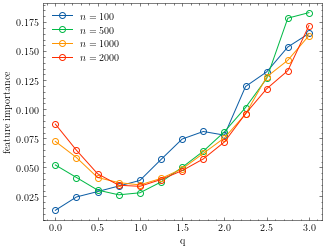

In [43]:
fig, ax = plt.subplots(figsize=(5, 4))

q_values = np.arange(0, 3.25, 0.25)

for i, n in enumerate((100, 500, 1000, 2000)):
    ax.plot(q_values, models[n]["impurity importances"], '-o', color=f"C{i}", label=f"$n={n}$", fillstyle="none")
ax.set(xlabel="q", ylabel="feature importance")
plt.legend()
plt.savefig(f"../plots/scenario1-feature-importance-gini.png", dpi=300)

### Permutation Based Feature Importance

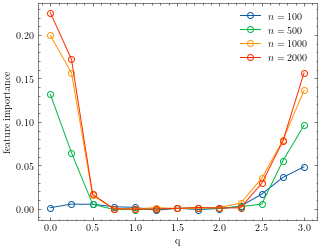

In [44]:
fig, ax = plt.subplots(figsize=(5, 4))

q_values = np.arange(0, 3.25, 0.25)

for i, n in enumerate((100, 500, 1000, 2000)):
    ax.plot(q_values, models[n]["permutation importances"], '-o', color=f"C{i}", label=f"$n={n}$", fillstyle="none")
ax.set(xlabel="q", ylabel="feature importance")
plt.legend(loc="upper right", ncol=1)
plt.savefig(f"../plots/scenario1-feature-importance-permutation.png", dpi=300);

In [45]:
SCENARIO1_TESTDATA = load_data("../data/scenario-1-testset-new.npz", draws=10)

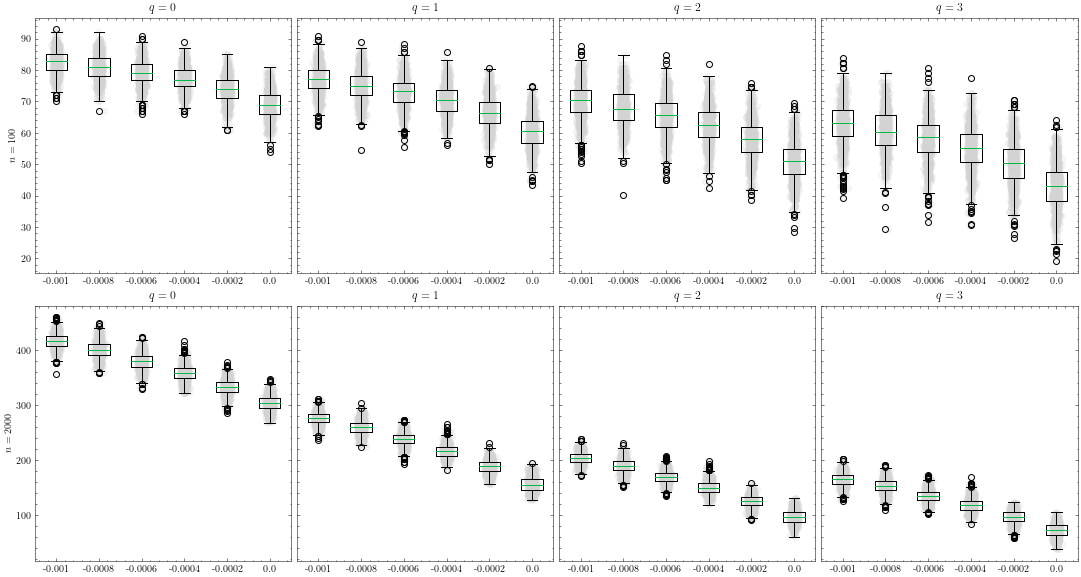

In [46]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(15, 8), sharey="row", constrained_layout=True)

bs = -0.001, -0.0008, -0.0006, -0.0004, -0.0002, 0.0
q_names = 0, 1, 2, 3
q_indexes = [i for i, q in enumerate(q_values) if q in q_names]

for k, n in enumerate((100, 2000)):
    data = SCENARIO1_TESTDATA[n]
    X, theta = data.dataset, data.theta
    Z = theta.numpy()

    for j, q in enumerate(q_indexes):
        mean_at_zero = X[(theta[:, 0] == 0).numpy(), q].mean().item()
        vals = []
        ys = []
        for i, b in enumerate(bs):
            target = (theta[:, 0] == b).numpy()
            ys.append(np.random.normal(i + 1, 0.04, target.sum()))
            vals.append(X[target, q].numpy())
        # TODO turn off minor ticks on y -axes
        axes[k, j].boxplot(vals, labels=bs)
        for i, (y, val), in enumerate(zip(ys, vals)):
            axes[k, j].scatter(y, val, alpha=0.2, color=f"lightgrey")
        axes[k, j].set_title(f"$q = {q_names[j]}$")
    axes[k, 0].set_ylabel(f"$n = {n}$")

In [47]:
ewens_results = [
    [0.0290, 0.0370, 0.0290, 0.0340, 0.0400, 0.0330, 0.0460, 0.0910, 0.4510, 0.9990, 1.0000, 1.0000],
    [0.5770, 0.5550, 0.4790, 0.3040, 0.1550, 0.0700, 0.0530, 0.1650, 0.6390, 1.0000, 1.0000, 1.0000],
    [0.9570, 0.9060, 0.7980, 0.5170, 0.2060, 0.0740, 0.0470, 0.1820, 0.6560, 1.0000, 1.0000, 1.0000],
    [0.9990, 0.9920, 0.9600, 0.7110, 0.3150, 0.1080, 0.0600, 0.1930, 0.6680, 1.0000, 1.0000, 1.0000]
]

ewens_results = pd.DataFrame(
    ewens_results, index=[100, 500, 1000, 2000], 
    columns=[-0.001, -0.0008, -0.0006, -0.0004, -0.0002, -0.0001, 
             0, 
             0.0001, 0.0002, 0.0003, 0.0004, 0.0005])

ewens_results = ewens_results.T
ewens_results

,100,500,1000,2000
-0.0010,0.029,0.577,0.957,0.999
-0.0008,0.037,0.555,0.906,0.992
-0.0006,0.029,0.479,0.798,0.960
-0.0004,0.034,0.304,0.517,0.711
-0.0002,0.040,0.155,0.206,0.315
-0.0001,0.033,0.070,0.074,0.108
0.0000,0.046,0.053,0.047,0.060
0.0001,0.091,0.165,0.182,0.193
0.0002,0.451,0.639,0.656,0.668
0.0003,0.999,1.000,1.000,1.000


100 0.6274975995610625
500 0.7263090947636208
1000 0.8321558885179721
2000 0.8664227243577652


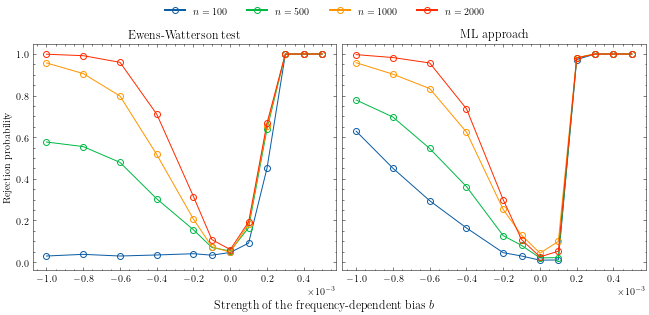

In [48]:
from matplotlib.lines import Line2D
import pandas as pd
from sklearn.metrics import f1_score

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True, constrained_layout=True)

for i, n in enumerate((100, 500, 1000, 2000)):
    axes[0].plot(ewens_results.index, ewens_results[n], '-o', color=f"C{i}", label=f"n={n}", fillstyle="none")
    

for i, n in enumerate((100, 500, 1000, 2000)):
    testdata = SCENARIO1_TESTDATA[n]

    X_test, theta_test = testdata.dataset, testdata.theta
    y_test = (theta_test[:, 0].numpy() != 0).astype(int)
    
    probs = models[n]["clf"].predict_proba(X_test)[:, 1]
    pred = (probs > 0.5).astype(float)
    score = f1_score(y_test, pred)
    print(n, score)
    
    df = pd.DataFrame(theta_test.numpy(), columns=["b", "p_mut", "p_death", "age_max", "_"])
    df["pred"] = pred
    df = df[df["b"].astype(np.float64).round(4).isin(ewens_results.index)]
    d = df.groupby("b")["pred"].mean()
    values, labels= d.values, d.index
    axes[1].plot(labels, values, '-o', color=f"C{i}", label=f"n={n}", fillstyle="none")    
    

fig.supxlabel('Strength of the frequency-dependent bias $b$')
axes[0].set_ylabel('Rejection probability')

axes[0].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
axes[1].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

axes[0].set_title("Ewens-Watterson test")
axes[1].set_title("ML approach")

custom_lines = [Line2D([0], [0], color="C0", lw=2, marker='o', fillstyle="none"),
                Line2D([0], [0], color="C1", lw=2, marker='o', fillstyle="none"),
                Line2D([0], [0], color="C2", lw=2, marker='o', fillstyle="none"),
                Line2D([0], [0], color="C3", lw=2, marker='o', fillstyle="none")]
fig.legend(custom_lines, ['$n=100$', '$n=500$', '$n=1000$', '$n=2000$'], 
          loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)

plt.savefig(f"../plots/scenario1.png", dpi=300)

## Scenario 2

age-structured model with b=0

* training data: (samples of) age-structured model with copyThresholdHigh $\in [2,\ldots,\text{All}]$ and pDeath $\in [0.02, 0.1]$
* observed data: samples (n=50,100,500,1000,2000) from age-structured model with specific $\text{copyThresholdHigh}_i$ values and $\text{pDeath}_i$ values
*outcome: 1-P(neutral)

As before plot the $\text{copyThresholdHigh}_i$  values on the x-axis and the 1-P(neutral) on the y-axis compare this to the rejection probability obtained from the Ewens-Watterson test (or even 3d plot with copyThresholdHigh_i values and $\text{pDeath}_i$ values on x and y axis)

In [49]:
SCENARIO2_TRAINDATA = load_data("../data/scenario-2-trainset-new.npz")

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

Estimator = RandomForestClassifier

models_2 = {}

for n in (100, 500, 1000, 2000):
    data = SCENARIO2_TRAINDATA[n]
    X, theta = data.dataset.numpy(), data.theta.numpy()
        
    X_train, X_dev, theta_train, theta_dev = train_test_split(
        X, theta, test_size=0.1, shuffle=True)
    y_train = (theta_train[:, 0] != 0).astype(int)
    y_dev = (theta_dev[:, 0] != 0).astype(int)
        
    clf = Estimator(n_jobs=4, **PARAMS[f"2-{n}"])

    clf.fit(X_train, y_train)

    probs = clf.predict_proba(X_dev)[:, 1]
    score = roc_auc_score(y_dev, probs)
    
    result = permutation_importance(
        clf, X_dev, y_dev, scoring="accuracy", n_repeats=50, n_jobs=4)
    
    models_2[n] = {
        "clf": clf,
        "dev score": score,
        "permutation importances": result.importances_mean,
        "impurity importances": clf.feature_importances_        
    }

/usr/local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

In [51]:
models_2

{100: {'clf': RandomForestClassifier(max_depth=10, min_samples_leaf=6, min_samples_split=17,
                         n_estimators=500, n_jobs=4),
  'dev score': 0.7914184195679401,
  'permutation importances': array([ 0.00246,  0.01726,  0.00084,  0.0047 , -0.00192, -0.00302,
         -0.005  , -0.00612, -0.00732, -0.00366,  0.03018,  0.05498,
          0.06246]),
  'impurity importances': array([0.03459566, 0.0502891 , 0.04058933, 0.03890361, 0.03870425,
         0.04805003, 0.05695859, 0.06939885, 0.08588762, 0.10147844,
         0.1219386 , 0.13535347, 0.17785244])},
 500: {'clf': RandomForestClassifier(criterion='entropy', max_depth=20, max_features='auto',
                         min_samples_leaf=9, min_samples_split=6,
                         n_estimators=1300, n_jobs=4),
  'dev score': 0.8391484731007278,
  'permutation importances': array([ 0.12754,  0.0832 ,  0.02142,  0.01574,  0.00338, -0.0014 ,
         -0.00196, -0.00188,  0.00366,  0.0245 ,  0.05508,  0.08984,
        

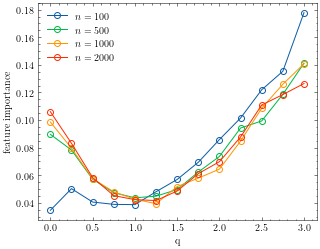

In [52]:
fig, ax = plt.subplots(figsize=(5, 4))

q_values = np.arange(0, 3.25, 0.25)

for i, n in enumerate((100, 500, 1000, 2000)):
    ax.plot(q_values, models_2[n]["impurity importances"], '-o', 
            color=f"C{i}", label=f"$n={n}$", fillstyle="none")
ax.set(xlabel="q", ylabel="feature importance")
plt.legend()
plt.savefig(f"../plots/scenario2-feature-importance-gini.png", dpi=300)

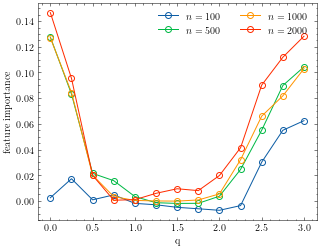

In [53]:
fig, ax = plt.subplots(figsize=(5, 4))

q_values = np.arange(0, 3.25, 0.25)

for i, n in enumerate((100, 500, 1000, 2000)):
    ax.plot(q_values, models_2[n]["permutation importances"], '-o', 
            color=f"C{i}", label=f"$n={n}$", fillstyle="none")
ax.set(xlabel="q", ylabel="feature importance")
plt.legend(loc="upper right", ncol=2)#bbox_to_anchor=(0.5, 1.15))
plt.savefig(f"../plots/scenario2-feature-importance-permutation.png", dpi=300);

In [54]:
SCENARIO2_TESTDATA = load_data("../data/scenario-2-testset-new.npz", draws=10)

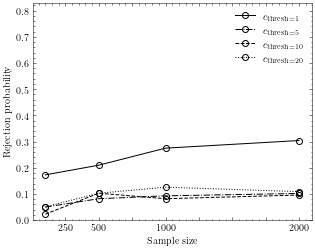

In [56]:
import pandas as pd
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(5, 4))

sample_sizes = np.array([100, 500, 1000, 2000])
cmax = np.array([1, 5, 10, 20])
p_death = 0.02
results = np.zeros((4, 4))
for j, n in enumerate(sample_sizes):
    testdata = SCENARIO2_TESTDATA[n]

    X_test, theta_test = testdata.dataset.numpy(), testdata.theta.numpy()
    y_test = (theta_test[:, 0] != 0).astype(int)

    index = (theta_test[:, 0] == 0.0) & (theta_test[:, 2] == p_death)

    X_test, y_test = X_test[index], y_test[index]

    probs = models_2[n]["clf"].predict_proba(X_test)[:, 1]
    pred = (probs > 0.5).astype(float)

    df = pd.DataFrame(theta_test[index], columns=["b", "p_mut", "p_death", "age_max", "_"])
    df["pred"] = pred
    d = df.groupby("age_max")["pred"].mean()
    results[j] = d.values
    
results = results.T
ls = '-', '-.', '--', 'dotted'
for j, n in enumerate(sample_sizes):
    ax.plot(sample_sizes, results[j], ls=ls[j], marker='o', fillstyle='none',
            color="k", label=f"$c_{{\\mathrm{{thresh}} = {cmax[j]}}}$")
ax.legend()
ax.xaxis.set_major_locator(ticker.FixedLocator(range(0, 2250, 250)))
ax.xaxis.set_major_formatter(ticker.FixedFormatter([0, 250, 500, '', 1000, '', '', '', 2000]))

ax.set(xlabel="Sample size", ylabel="Rejection probability", ylim=(0, 0.83))
plt.savefig(f"../plots/scenario2-cmax-plot.png", dpi=300);

## Figure 4a and 4b:

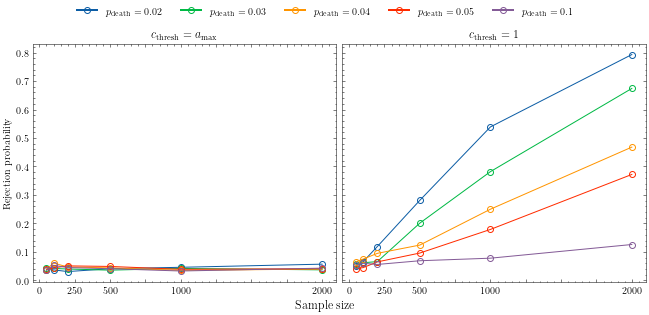

In [58]:
all_scenario = pd.DataFrame([
     [0.0380, 0.0370, 0.0310, 0.0410, 0.0460, 0.0570],
     [0.0440, 0.0420, 0.0400, 0.0360, 0.0420, 0.0370],
     [0.0380, 0.0610, 0.0470, 0.0440, 0.0350, 0.0400],
     [0.0390, 0.0440, 0.0510, 0.0490, 0.0390, 0.0410],
     [0.0350, 0.0530, 0.0450, 0.0410, 0.0330, 0.0430]],
    index=[0.02, 0.03, 0.04, 0.05, 0.1], 
    columns=[50, 100, 200, 500, 1000, 2000]).T

one_scenario = pd.DataFrame([
    [0.0490, 0.0660, 0.1190, 0.2810, 0.5390, 0.7930],
    [0.0570, 0.0620, 0.0660, 0.2010, 0.3820, 0.6740], 
    [0.0660, 0.0750, 0.0950, 0.1240, 0.2500, 0.4680],
    [0.0410, 0.0450, 0.0650, 0.0960, 0.1790, 0.3720],
    [0.0550, 0.0600, 0.0560, 0.0690, 0.0780, 0.1260]],
    index=[0.02, 0.03, 0.04, 0.05, 0.1], 
    columns=[50, 100, 200, 500, 1000, 2000]).T

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True, constrained_layout=True)

scenarios = all_scenario, one_scenario
for i, scenario in enumerate(scenarios):
    for j, p_death in enumerate(scenario.columns):
        axes[i].plot(scenario.index, scenario[p_death].values, '-o',
                     color=f"C{j}", label=f"n={n}", fillstyle="none")

fig.supxlabel('Sample size')
axes[0].set_ylabel('Rejection probability')

axes[0].set_title(r"$c_{\mathrm{thresh}} = a_{\mathrm{max}}$")
axes[1].set_title(r"$c_{\mathrm{thresh}} = 1$")

for ax in axes:
    ax.xaxis.set_major_locator(ticker.FixedLocator(range(0, 2250, 250)))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter([0, 250, 500, '', 1000, '', '', '', 2000]))

custom_lines = [Line2D([0], [0], color="C0", lw=2, marker='o', fillstyle="none"),
                Line2D([0], [0], color="C1", lw=2, marker='o', fillstyle="none"),
                Line2D([0], [0], color="C2", lw=2, marker='o', fillstyle="none"),
                Line2D([0], [0], color="C3", lw=2, marker='o', fillstyle="none"),
                Line2D([0], [0], color="C4", lw=2, marker='o', fillstyle="none")]
labels = [fr'$p_{{\mathrm{{death}}}} = {pd}$' for pd in one_scenario.columns]
fig.legend(custom_lines, labels, 
          loc="upper center", ncol=5, bbox_to_anchor=(0.5, 1.1), frameon=False)
plt.savefig("../plots/pDeath-comparison.png", dpi=300)

## Figure 5

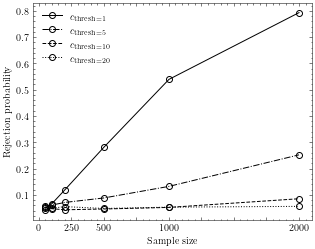

In [59]:
import matplotlib.ticker as ticker

age_pop = pd.DataFrame([
    [0.0490, 0.0660, 0.1190, 0.2810, 0.5390, 0.7930],
    [0.0560, 0.0610, 0.0710, 0.0880, 0.1320, 0.2520],
    [0.0520, 0.0470, 0.0430, 0.0460, 0.0520, 0.0850],
    [0.0410, 0.0490, 0.0550, 0.0480, 0.0530, 0.0560]],
    index=[1, 5, 10, 20], columns=[50, 100, 200, 500, 1000, 2000]).T

fig, ax = plt.subplots(figsize=(5, 4))
ls = '-', '-.', '--', 'dotted'
cmax = np.array([1, 5, 10, 20])
for j, n in enumerate(age_pop.columns):
    ax.plot(age_pop.index, age_pop[n].values, ls=ls[j], marker='o', markerfacecolor='none',
            color="k", label=f"$c_{{\\mathrm{{thresh}} = {cmax[j]}}}$")

ax.xaxis.set_major_locator(ticker.FixedLocator(range(0, 2250, 250)))
ax.xaxis.set_major_formatter(ticker.FixedFormatter([0, 250, 500, '', 1000, '', '', '', 2000]))
ax.legend()
ax.set(xlabel="Sample size", ylabel="Rejection probability")
plt.savefig("../plots/rej_thresh_b0_pDeath02-new.png", dpi=300)

## Scenario 3

age-structured model with $b \approx 0$

* training data: (samples of) age-structured model with copyThresholdHigh $\in[2,…,All]$ and pDeath $\in [0.02,0.1]$ and $b \in[-0.001,0.0006]$
* observed data: samples (n=50,100,500,1000,2000) from age-structured model with specific copyThresholdHigh_i values and pDeath_i values and $b_i$ values
* outcome: 1-P(neutral)

In [60]:
betas = np.array(
    [-0.001, -0.0008, -0.0006, -0.0004, -0.0002, -0.0001, 
     0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005])

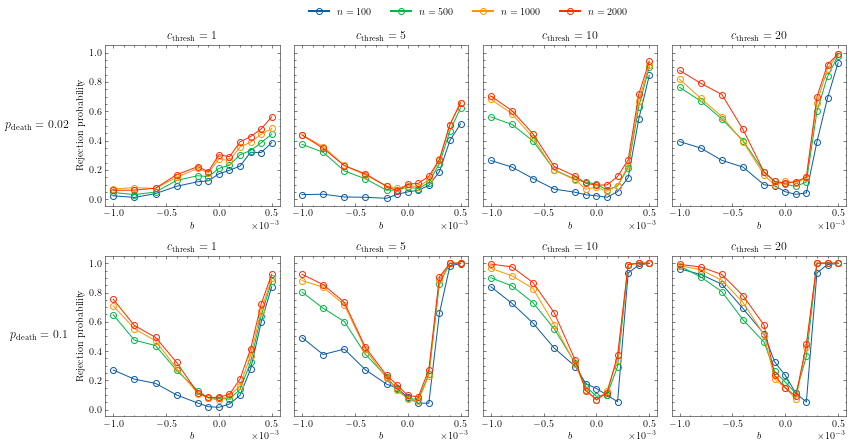

In [61]:
import pandas as pd
import sklearn.metrics as metrics
from matplotlib.lines import Line2D

fig, axes = plt.subplots(ncols=4, nrows=2, sharey=True, figsize=(12, 6))

roc_curves = {}

for j, n in enumerate((100, 500, 1000, 2000)):
    testdata = SCENARIO2_TESTDATA[n]

    for i, p_death in enumerate((0.02, 0.1)):

        X_test, theta_test = testdata.dataset.numpy(), testdata.theta.numpy()
        y_test = (theta_test[:, 0] != 0).astype(int)
        
        index = ((theta_test[:, 2] == p_death) & np.isin(theta_test[:, 0], betas))
        
        X_test, y_test = X_test[index], y_test[index]

        probs = models_2[n]["clf"].predict_proba(X_test)[:, 1]
        pred = (probs >= 0.5).astype(float)

        df = pd.DataFrame(theta_test[index], columns=["b", "p_mut", "p_death", "age_max", "_"])
        df["pred"] = pred
        df["prob"] = probs
        for k, (age, g) in enumerate(df.groupby("age_max")):
            roc_curves[n, p_death, age] = metrics.roc_curve((
                g["b"] != 0).astype(int).values, g["prob"].values)
            g = g.groupby("b")["pred"].mean()
            axes[i, k].plot(g.index, g.values, '-o', color=f"C{j}", fillstyle="none")
            axes[i, k].set(xlabel="$b$", title=f"$c_{{\\mathrm{{thresh}}}} = {int(age) - 1}$")
            axes[i, k].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    
        axes[i, 0].set(ylabel="Rejection probability")

rows = [f'$p_{{\\mathrm{{death}}}} = {v}$' for v in (0.02, 0.1)]
pad = 5
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
custom_lines = [Line2D([0], [0], color="C0", lw=2, marker='o', fillstyle="none"),
                Line2D([0], [0], color="C1", lw=2, marker='o', fillstyle="none"),
                Line2D([0], [0], color="C2", lw=2, marker='o', fillstyle="none"),
                Line2D([0], [0], color="C3", lw=2, marker='o', fillstyle="none")]
fig.legend(custom_lines, ['$n=100$', '$n=500$', '$n=1000$', '$n=2000$'], 
          loc="upper center", ncol=4, bbox_to_anchor=(0.55, 1.05), frameon=False)

plt.tight_layout()
plt.savefig("../plots/scenario3-rejection.png", dpi=300, bbox_inches='tight')

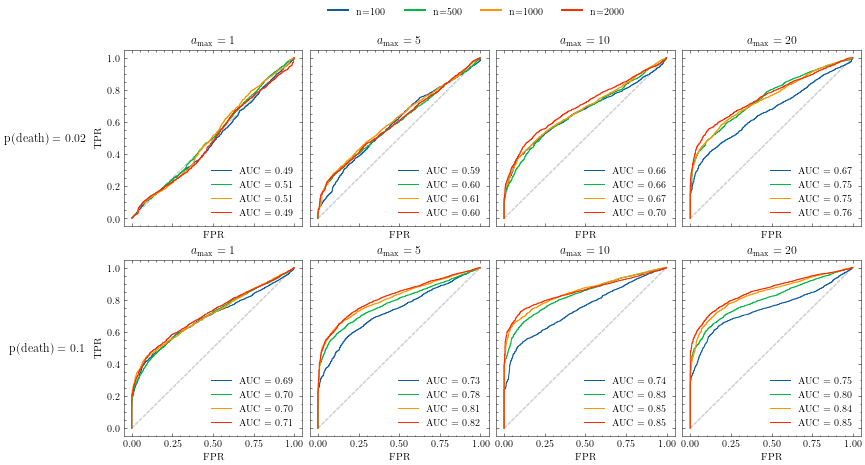

In [62]:
fig, axes = plt.subplots(
    nrows=2, ncols=4, sharey=True, sharex=True, figsize=(12, 6),
    constrained_layout=True
)
for j, n in enumerate((100, 500, 1000, 2000)):
    for i, p_death in enumerate((0.02, 0.1)):
        for k, age in enumerate((2, 6, 11, 21)):
            fpr, tpr, _ = roc_curves[n, p_death, age]
            roc_auc = metrics.auc(fpr, tpr)
            axes[i, k].plot(
                fpr, tpr, '-', color=f"C{j}", label=f"AUC = {roc_auc:.2f}")
            axes[i, k].set(xlabel="FPR", title=f"$a_{{\\mathrm{{max}}}} = {int(age) - 1}$")
            axes[i, k].legend(loc="lower right")
            axes[i, k].plot([0, 1], [0, 1], color="lightgrey", linestyle="--", zorder=-1)
        axes[i, 0].set(ylabel="TPR")
        
rows = [f'p(death) = {v}' for v in (0.02, 0.1)]
pad = 5
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
custom_lines = [Line2D([0], [0], color="C0", lw=2),
                Line2D([0], [0], color="C1", lw=2),
                Line2D([0], [0], color="C2", lw=2),
                Line2D([0], [0], color="C3", lw=2)]
fig.legend(custom_lines, ['n=100', 'n=500', 'n=1000', 'n=2000'], 
          loc="upper center", ncol=4, bbox_to_anchor=(0.55, 1.08), frameon=False)
plt.savefig("roc_curves.png", dpi=300, bbox_inches='tight')

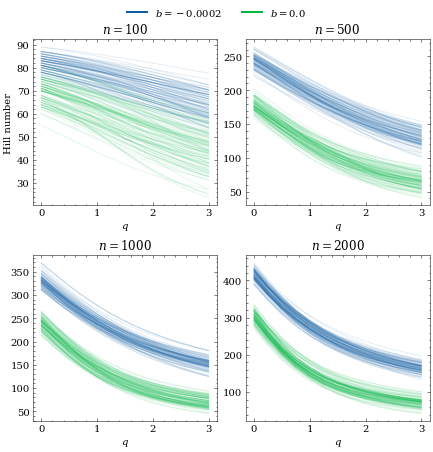

In [463]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(6, 6), constrained_layout=True)
axes = axes.flatten()

betas = np.array([-0.001, 0.0], dtype=np.float32)
q = np.arange(0, 3.25, 0.25)

for j, n in enumerate((100, 500, 1000, 2000)):
    data = SCENARIO1_TESTDATA[n]
    df = pd.DataFrame(
        data.theta.numpy().astype(np.float64), 
        columns=["b", "p_mut", "p_death", "age_max", "timesteps"]
    )
    
    for i, beta in enumerate(betas):
        samples = data.dataset[df["b"] == beta]
        samples = samples[np.random.randint(0, len(samples), 100)]
        for sample in samples:
            axes[j].plot(q, sample, alpha=0.1, color=f"C{i}")
    axes[j].set(xlabel="$q$", title=f"$n={n}$")

axes[0].set_ylabel("Hill number")

custom_lines = [Line2D([0], [0], color="C0", lw=2),
                Line2D([0], [0], color="C1", lw=2),
                Line2D([0], [0], color="C2", lw=2),
                Line2D([0], [0], color="C3", lw=2)]
fig.legend(custom_lines, ['$b=-0.0002$', '$b=0.0$'], 
          loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.05), frameon=False)

plt.savefig(f"../plots/hill_numbers_scenario1.png", dpi=300, bbox_inches='tight')

In [63]:
SCENARIO2_TESTDATA_FULL = load_data("../data/scenario-2-testset-full.npz", draws=10)

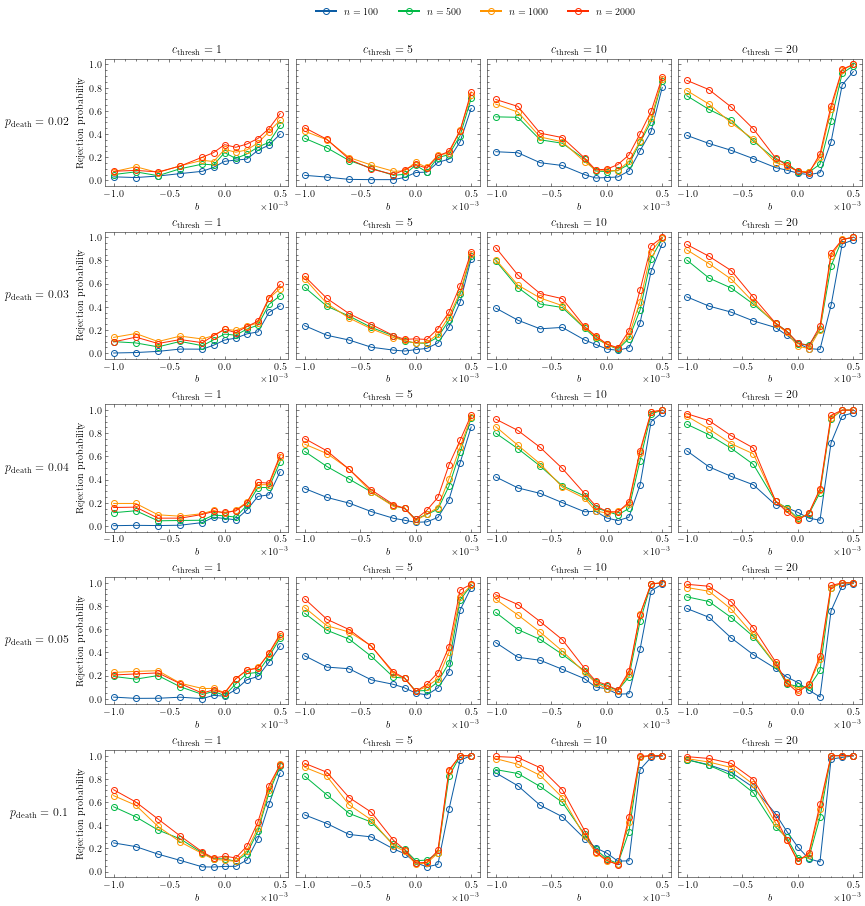

In [64]:
fig, axes = plt.subplots(ncols=4, nrows=5, sharey=True, figsize=(12, 12), constrained_layout=True)

p_death_vals = (0.02, 0.03, 0.04, 0.05, 0.1)
roc_curves = {}

for j, n in enumerate((100, 500, 1000, 2000)):
    testdata = SCENARIO2_TESTDATA_FULL[n]

    for i, p_death in enumerate(p_death_vals):

        X_test, theta_test = testdata.dataset.numpy(), testdata.theta.numpy()
        y_test = (theta_test[:, 0] != 0).astype(int)
        
        index = ((theta_test[:, 2] == p_death) & np.isin(theta_test[:, 0], betas))
        
        X_test, y_test = X_test[index], y_test[index]

        probs = models_2[n]["clf"].predict_proba(X_test)[:, 1]
        pred = (probs > 0.5).astype(float)

        df = pd.DataFrame(theta_test[index], columns=["b", "p_mut", "p_death", "age_max", "_"])
        df["pred"] = pred
        df["prob"] = probs
        for k, (age, g) in enumerate(df.groupby("age_max")):
            roc_curves[n, p_death, age] = metrics.roc_curve((
                g["b"] != 0).astype(int).values, g["prob"].values)
            g = g.groupby("b")["pred"].mean()
            axes[i, k].plot(g.index, g.values, '-o', color=f"C{j}", fillstyle="none")
            axes[i, k].set(xlabel="$b$", title=f"$c_{{\\mathrm{{thresh}}}} = {int(age) - 1}$")
            axes[i, k].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    
        axes[i, 0].set(ylabel="Rejection probability")

rows = [f'$p_{{\\mathrm{{death}}}} = {v}$' for v in p_death_vals]
pad = 5
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
custom_lines = [Line2D([0], [0], color="C0", lw=2, marker='o', fillstyle="none"),
                Line2D([0], [0], color="C1", lw=2, marker='o', fillstyle="none"),
                Line2D([0], [0], color="C2", lw=2, marker='o', fillstyle="none"),
                Line2D([0], [0], color="C3", lw=2, marker='o', fillstyle="none")]
fig.legend(custom_lines, ['$n=100$', '$n=500$', '$n=1000$', '$n=2000$'], 
          loc="upper center", ncol=4, bbox_to_anchor=(0.55, 1.05), frameon=False)

plt.savefig("../plots/scenario3-rejection-full.png", dpi=300, bbox_inches='tight')

In [65]:
SCENARIO_FIXED_PDEATH_TRAINDATA = load_data("../data/scenario-2-trainset-fixed-pdeath.npz")

In [92]:
with open("clf_params-rf-fixed-pdeath.json") as f:
    FIXED_PDEATH_PARAMS = json.load(f)

Estimator = RandomForestClassifier

models_fixed_pdeath = {}

for n in (100, 500, 1000, 2000):
    data = SCENARIO_FIXED_PDEATH_TRAINDATA[n]
    X, theta = data.dataset.numpy(), data.theta.numpy()
        
    X_train, X_dev, theta_train, theta_dev = train_test_split(
        X, theta, test_size=0.05, shuffle=True)
    y_train = (theta_train[:, 0] != 0).astype(int)
    y_dev = (theta_dev[:, 0] != 0).astype(int)
        
    clf = Estimator(n_jobs=4, **FIXED_PDEATH_PARAMS[f"2-{n}"])

    clf.fit(X_train, y_train)

    probs = clf.predict_proba(X_dev)[:, 1]
    score = roc_auc_score(y_dev, probs)
    
    models_fixed_pdeath[n] = {
        "clf": clf,
        "dev score": score,
    }

/usr/local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [93]:
models_fixed_pdeath

{100: {'clf': RandomForestClassifier(max_depth=10, max_features='auto', min_samples_leaf=9,
                         min_samples_split=18, n_estimators=1200, n_jobs=4),
  'dev score': 0.7861212014530092},
 500: {'clf': RandomForestClassifier(max_depth=20, max_features='log2', min_samples_leaf=9,
                         min_samples_split=7, n_estimators=900, n_jobs=4),
  'dev score': 0.8266447209178487},
 1000: {'clf': RandomForestClassifier(criterion='entropy', max_depth=20, max_features='auto',
                         min_samples_leaf=9, min_samples_split=6,
                         n_estimators=1300, n_jobs=4),
  'dev score': 0.7594933670448543},
 2000: {'clf': RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=9,
                         min_samples_split=11, n_estimators=900, n_jobs=4),
  'dev score': 0.7992286714753675}}

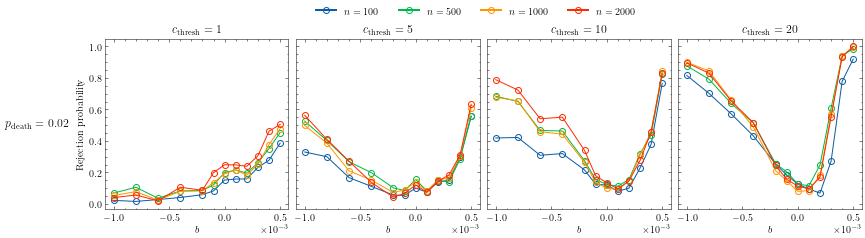

In [69]:
fig, axes = plt.subplots(ncols=4, nrows=1, sharey=True, figsize=(12, 3), constrained_layout=True)

p_death_vals = (0.02,)
roc_curves = {}

for j, n in enumerate((100, 500, 1000, 2000)):
    testdata = SCENARIO2_TESTDATA_FULL[n]

    for i, p_death in enumerate(p_death_vals):

        X_test, theta_test = testdata.dataset.numpy(), testdata.theta.numpy()
        y_test = (theta_test[:, 0] != 0).astype(int)
        
        index = ((theta_test[:, 2] == p_death) & np.isin(theta_test[:, 0], betas))
        
        X_test, y_test = X_test[index], y_test[index]

        probs = models_fixed_pdeath[n]["clf"].predict_proba(X_test)[:, 1]
        pred = (probs > 0.5).astype(float)

        df = pd.DataFrame(theta_test[index], columns=["b", "p_mut", "p_death", "age_max", "_"])
        df["pred"] = pred
        df["prob"] = probs
        for k, (age, g) in enumerate(df.groupby("age_max")):
            roc_curves[n, p_death, age] = metrics.roc_curve((
                g["b"] != 0).astype(int).values, g["prob"].values)
            g = g.groupby("b")["pred"].mean()
            axes[k].plot(g.index, g.values, '-o', color=f"C{j}", fillstyle="none")
            axes[k].set(xlabel="$b$", title=f"$c_{{\\mathrm{{thresh}}}} = {int(age) - 1}$")
            axes[k].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    
        axes[0].set(ylabel="Rejection probability")

rows = [f'$p_{{\\mathrm{{death}}}} = {v}$' for v in p_death_vals]
pad = 5
for ax, row in zip(axes, rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
custom_lines = [Line2D([0], [0], color="C0", lw=2, marker='o', fillstyle="none"),
                Line2D([0], [0], color="C1", lw=2, marker='o', fillstyle="none"),
                Line2D([0], [0], color="C2", lw=2, marker='o', fillstyle="none"),
                Line2D([0], [0], color="C3", lw=2, marker='o', fillstyle="none")]
fig.legend(custom_lines, ['$n=100$', '$n=500$', '$n=1000$', '$n=2000$'], 
          loc="upper center", ncol=4, bbox_to_anchor=(0.55, 1.11), frameon=False)

plt.savefig("../plots/scenario3-fixed-pdeath-training.png", dpi=300)

## Learning Curves

### Scenario 1

In [206]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

Estimator = RandomForestClassifier
train_sizes = np.linspace(0.1, 1.0, 10)

train_curve_results_scenario1 = {}

for n in (100, 500, 1000, 2000):
    print(n)
    data = SCENARIO1_TRAINDATA[n]
    X, theta = data.dataset, data.theta
    y = (theta[:, 0].numpy() != 0).astype(int)

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        Estimator(n_jobs=10, **PARAMS[f"1-{n}"]),
        X, y,
        cv=ShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
        n_jobs=6,
        scoring="accuracy",
        train_sizes=train_sizes,
        return_times=True,
    )
    
    train_curve_results_scenario1[n] = {
        "train sizes": train_sizes,
        "train scores": train_scores,
        "test scores": test_scores,
        "fit times": fit_times
    }

100
500
1000
2000


In [221]:
def plot_learning_curve(scores, train_sizes, ax=None, figsize=None, ylim=(0.5, 1.0)):
    if ax is None:
        fig, axes = plt.subplots(
            ncols=len(scores), sharey=True, sharex=True, constrained_layout=True, figsize=figsize)
    
    for i, n in enumerate(sorted(scores.keys())):
        train_scores_mean = np.mean(scores[n]["train scores"], axis=1)
        train_scores_std = np.std(scores[n]["train scores"], axis=1)
        test_scores_mean = np.mean(scores[n]["test scores"], axis=1)
        test_scores_std = np.std(scores[n]["test scores"], axis=1)
                
        axes[i].plot(train_sizes, train_scores_mean, 'o-', color="C0", fillstyle="none")
        axes[i].plot(train_sizes, test_scores_mean, 'o-', color="C1", fillstyle="none")
        
        axes[i].fill_between(
            train_sizes,
            train_scores_mean - train_scores_std,
            train_scores_mean + train_scores_std,
            alpha=0.1,
            color=f"C0"
        )
        
        axes[i].fill_between(
            train_sizes,
            test_scores_mean - test_scores_std,
            test_scores_mean + test_scores_std,
            alpha=0.1,
            color="C1"
        )
        
        axes[i].set_title(f"$n={n}$", fontsize='medium')
        axes[i].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
        axes[i].set_ylim(*ylim)
        
    fig.supxlabel('Number of training examples', y=-0.1)        
    axes[0].set(ylabel="Accuracy score")
    plt.figlegend(["Training data", 'Held-out data'], 
                  loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.1), 
                  frameon=False)
    return fig, axes

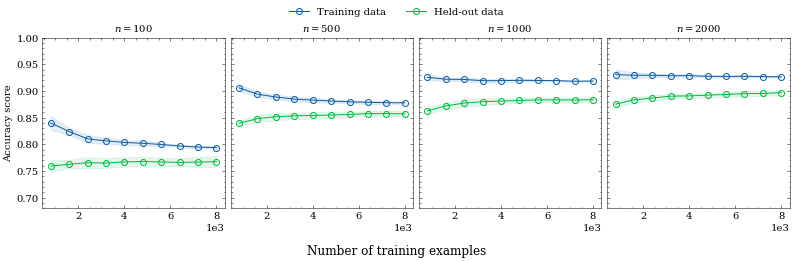

In [228]:
plot_learning_curve(train_curve_results_scenario1, train_sizes, figsize=(11, 3), ylim=(0.68, 1.0))
plt.savefig("../plots/learning-curve-scenario1.png", dpi=300, bbox_inches='tight')

### Scenario 2/3

In [229]:
Estimator = RandomForestClassifier
train_sizes = np.linspace(0.1, 1.0, 10)

train_curve_results_scenario2 = {}

for n in (100, 500, 1000, 2000):
    print(n)
    data = SCENARIO2_TRAINDATA[n]
    X, theta = data.dataset, data.theta
    y = (theta[:, 0].numpy() != 0).astype(int)

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        Estimator(n_jobs=10, **PARAMS[f"2-{n}"]),
        X, y,
        cv=ShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
        n_jobs=6,
        scoring="accuracy",
        train_sizes=train_sizes,
        return_times=True,
    )
    
    train_curve_results_scenario2[n] = {
        "train sizes": train_sizes,
        "train scores": train_scores,
        "test scores": test_scores,
        "fit times": fit_times
    }

100
500
1000
2000


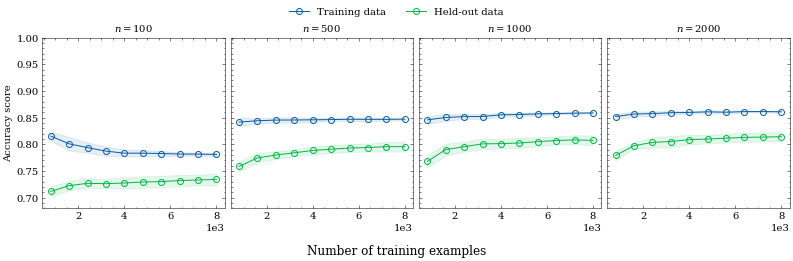

In [231]:
plot_learning_curve(train_curve_results_scenario2, train_sizes, figsize=(11, 3), ylim=(0.68, 1.0))
plt.savefig("../plots/learning-curve-scenario2.png", dpi=300, bbox_inches='tight')